## Семинар 7: "Методы оптимизации"

ФИО: Александр Лыжов

In [51]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
%matplotlib inline
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.patches as mpatches

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [10]:
def gd(fder, varnum = 2, iters = 30000, alpha = 0.0001):
    variables = np.random.normal(0, 1, size = (varnum))
    for i in xrange(iters):
        grad = fder(*variables)
        variables -= alpha * grad
    return variables

In [3]:
def momentum(fder, varnum = 2, iters = 30000, alpha = 0.0001, gamma = 0.9):
    mom = np.random.normal(0, 1, size = (2))
    variables = np.random.normal(0, 1, size = (varnum))
    for i in xrange(iters):
        grad = fder(*variables)
        mom = gamma * mom + alpha * grad
        variables -= mom
    return variables

In [4]:
def nag(fder, varnum = 2, iters = 30000, alpha = 0.0001, gamma = 0.9):
    mom = np.random.normal(0, 1, size = (2))
    variables = np.random.normal(0, 1, size = (varnum))
    for i in xrange(iters):
        new_variables = variables - gamma * mom
        grad = fder(*new_variables)
        mom = gamma * mom + alpha * grad
        variables -= mom
    return variables

In [5]:
def adagrad(fder, varnum = 2, iters = 30000, alpha = 0.01, epsilon = 1e-5):
    variables = np.random.normal(0, 1, size = (varnum))
    gradsum = np.zeros((varnum))
    for i in xrange(iters):
        grad = fder(*variables)
        for i in xrange(grad.shape[0]):
            gradsum[i] += grad[i]**2
            variables[i] -= alpha * grad[i] / (np.sqrt(gradsum[i]) + epsilon)
    return variables

In [25]:
def adadelta(fder, varnum = 2, iters = 30000, gamma = 0.9, epsilon = 1e-5):
    variables = np.random.normal(0, 1, size = (varnum))
    gradsum = np.zeros((varnum))
    varsum = np.full((varnum), 0.01)
    for i in xrange(iters):
        grad = fder(*variables)
        gradsum = gamma * gradsum + (1 - gamma) * grad**2
        vardelta = np.sqrt(varsum + epsilon) / np.sqrt(gradsum + epsilon) * grad
        varsum = gamma * varsum + (1 - gamma) * vardelta**2
        variables -= vardelta
    return variables

In [29]:
def adam(fder, varnum = 2, iters = 30000, alpha = 0.001, beta1 = 0.9, beta2 = 0.999, epsilon = 10e-8):
    variables = np.random.normal(0, 1, size = (varnum))
    m = np.zeros((varnum))
    v = np.zeros((varnum))
    for i in xrange(iters):
        grad = fder(*variables)
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * grad**2
        mcor = m / (1 - beta1**(i + 1))
        vcor = v / (1 - beta2**(i + 1))
        variables -= alpha * mcor / (np.sqrt(vcor) + epsilon)
    return variables

In [30]:
def print_res(f, fder, opt, name):
    x, y = opt(fder)
    val = f(x, y)
    print(name + ': val = {:.5f}'.format(val) + ', x = {:.5f}'.format(x) + ', y = {:.5f}'.format(y))

In [34]:
def analyze(f, fder):
    print_res(f, fder, gd, 'GD')
    print_res(f, fder, momentum, 'Momentum')
    print_res(f, fder, nag, 'NAG')
    print_res(f, fder, adagrad, 'Adagrad')
    print_res(f, fder, adadelta, 'Adadelta')
    print_res(f, fder, adam, 'Adam')

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [35]:
f = lambda x, y: x**2 + y**2 # zeros: 0
fder = lambda x, y: np.array((2 * x, 2 * y))
analyze(f, fder)

GD: val = 0.00003, x = -0.00151, y = -0.00482
Momentum: val = 0.00000, x = -0.00000, y = -0.00000
NAG: val = 0.00000, x = -0.00000, y = -0.00000
Adagrad: val = 0.00000, x = 0.00000, y = 0.00000
Adadelta: val = 0.00000, x = -0.00000, y = -0.00000
Adam: val = 0.00000, x = -0.00002, y = -0.00000


<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [36]:
f = lambda x, y: x**2 * np.sin(x) + y**2 * np.sin(y) # zeros: 0, +-2.2, +-5.0, ...
fder = lambda x, y: np.array((2 * x * np.sin(x) + x**2 * np.cos(x),
                              2 * y * np.sin(y) + y**2 * np.cos(y)))
analyze(f, fder)

GD: val = 0.00099, x = 0.07538, y = 0.08262
Momentum: val = -67.58028, x = -8.09616, y = -2.28893
NAG: val = -324.71939, x = 11.17271, y = -14.27635
Adagrad: val = -3.94530, x = 0.00826, y = -2.28892
Adadelta: val = -7.56599, x = -2.47757, y = -2.47758
Adam: val = -7.89060, x = -2.28893, y = -2.28893


<i>1.3 Сравните эти методы на функции J(x,y)=x^2sin(x^2)+y^2sin(y^2)</i>

In [37]:
f = lambda x, y: x**2 * np.sin(x**2) + y**2 * np.sin(y**2) # zeros: 0, +-1.4, +-2.2, +-2.8, ...
fder = lambda x, y: np.array(((2 * x * np.sin(x**2) + x**2 * np.cos(x**2) * 2 * x,
                               2 * y * np.sin(y**2) + y**2 * np.cos(y**2) * 2 * y)))
analyze(f, fder)

GD: val = 0.00160, x = -0.08366, y = 0.19838
Momentum: val = -9.62894, x = 2.21657, y = 2.21657
NAG: val = -40.90257, x = -5.46613, y = 3.32950
Adagrad: val = -4.81439, x = 0.09372, y = 2.21657
Adadelta: val = -4.07386, x = -0.00204, y = 2.33152
Adam: val = 0.00000, x = 0.00006, y = -0.00010


###  Часть 2: Обучение нейронной сети

In [108]:
def learn(model, optimizer, epochs, np_images_train, np_labels_train,
          np_images_test, np_labels_test, interval):
    lossf = torch.nn.NLLLoss()
    batchsize = 128
    iters = int(np.ceil(float(np_images_train.shape[0]) / batchsize))
    measures = int(np.ceil(float(iters) / interval))
    losses = np.zeros((epochs * measures, 2))
    acc = np.zeros((epochs * measures, 2))

    for ep in xrange(epochs):
        p = np.random.permutation(len(np_labels_train))
        np_images_train = np_images_train[p, :]
        np_labels_train = np_labels_train[p]

        images_train = torch.from_numpy(np_images_train).type(torch.FloatTensor)
        labels_train = torch.from_numpy(np_labels_train)
        images_test = torch.from_numpy(np_images_test).type(torch.FloatTensor)
        labels_test = torch.from_numpy(np_labels_test)

        for i in tqdm(xrange(iters)):
            # train
            X = Variable(images_train[i * batchsize:(i + 1) * batchsize])
            y = Variable(labels_train[i * batchsize:(i + 1) * batchsize], requires_grad=False)
            output = model.forward(X)
            loss = lossf(output, y)
            
            if i % interval == 0:
                losses[ep * measures + (i / interval), 0] = loss.data.numpy()[0]
                y_data = y.data.numpy()
                pred_data = output.data.numpy()
                acc[ep * measures + (i / interval), 0] = accuracy_score(y_data, pred_data.argmax(axis = 1))
            
                # test
                p = np.random.randint(len(np_labels_test), size = batchsize)
                cur_images = np_images_test[p, :]
                cur_labels = np_labels_test[p]

                test_x = Variable(torch.from_numpy(cur_images))
                test_y = Variable(torch.from_numpy(cur_labels))

                test_y_pred = model.forward(test_x)
                test_loss = lossf(test_y_pred, test_y)
                losses[ep * measures + (i / interval), 1] = test_loss.data.numpy()[0]
                y_data = test_y.data.numpy()
                pred_data = test_y_pred.data.numpy()
                acc[ep * measures + (i / interval), 1] = accuracy_score(y_data, pred_data.argmax(axis = 1))
            
            # back
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return losses, acc

In [ ]:
def plot(data, xlabel, ylabel, label1, label2, xdata = None):
    if xdata is None:
        xdata = xrange(data.shape[0])
    c1 = np.random.random_sample((3,))
    c2 = np.random.random_sample((3,))
    plt.plot(xdata, data[:, 0], color = c1, alpha = 0.8)
    plt.plot(xdata, data[:, 1], color = c2, alpha = 0.8)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    patch1 = mpatches.Patch(color=c1, label=label1)
    patch2 = mpatches.Patch(color=c2, label=label2)
    plt.legend(handles=[patch1, patch2])

In [ ]:
def plot_losses_acc(losses, acc, interval):
    plt.figure(1, figsize = (10, 3))
    plt.subplot(1, 2, 1)
    plot(losses, 'Iters', 'Loss', 'Train loss', 'Test loss', np.arange(losses.shape[0]) * interval)
    plt.subplot(1, 2, 2)
    plot(acc, 'Iters', 'Accuracy', 'Train accuracy', 'Test accuracy', np.arange(acc.shape[0]) * interval)

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, NAG и SGD. </i>

In [124]:
mnist = fetch_mldata('MNIST original', data_home='~/.datasets')
images = mnist['data']
# images = images.reshape(images.shape[0], 1, 28, 28) # data dims: examples x channels x w x h
images = images.astype(np.float32) / 255 # float and normalize
labels = mnist['target'].astype(int)
np_images_train, np_images_test, np_labels_train, np_labels_test = train_test_split(images, labels)

In [128]:
# Adam
indim = np_images_train.shape[1]
model = nn.Sequential(nn.Linear(indim, 30), nn.Tanh(), nn.Linear(30, 30), nn.Tanh(),
              nn.Linear(30, 10), nn.LogSoftmax())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
interval = 50
losses, acc = learn(model, optimizer, 1, np_images_train, np_labels_train,
                    np_images_test, np_labels_test, interval)

100%|██████████| 411/411 [00:01<00:00, 385.85it/s]


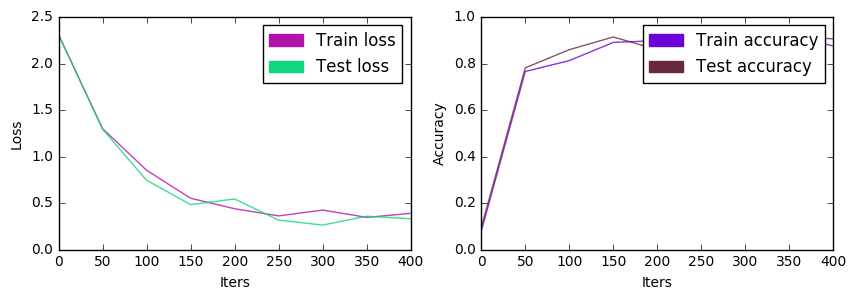

In [129]:
plot_losses_acc(losses, acc, interval)

In [130]:
# SGD
indim = np_images_train.shape[1]
model = nn.Sequential(nn.Linear(indim, 30), nn.Tanh(), nn.Linear(30, 30), nn.Tanh(),
              nn.Linear(30, 10), nn.LogSoftmax())
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
interval = 50
losses, acc = learn(model, optimizer, 1, np_images_train, np_labels_train,
                    np_images_test, np_labels_test, interval)

100%|██████████| 411/411 [00:00<00:00, 468.48it/s]


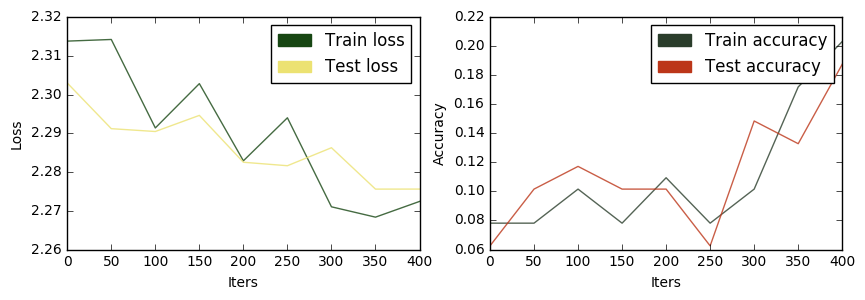

In [131]:
plot_losses_acc(losses, acc, interval)

In [132]:
# NAG
indim = np_images_train.shape[1]
model = nn.Sequential(nn.Linear(indim, 30), nn.Tanh(), nn.Linear(30, 30), nn.Tanh(),
                      nn.Linear(30, 10), nn.LogSoftmax())
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9, nesterov = True)
interval = 50
losses, acc = learn(model, optimizer, 1, np_images_train, np_labels_train,
                    np_images_test, np_labels_test, interval)

100%|██████████| 411/411 [00:00<00:00, 532.11it/s]


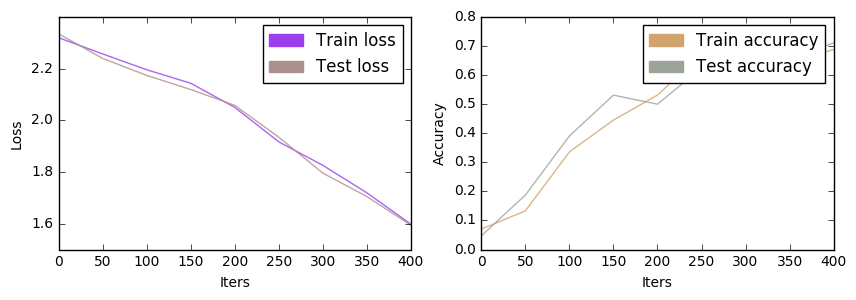

In [133]:
plot_losses_acc(losses, acc, interval)

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, NAG и SGD. </i>

In [ ]:
mnist = fetch_mldata('MNIST original', data_home='~/.datasets')
images = mnist['data']
images = images.reshape(images.shape[0], 1, 28, 28) # data dims: examples x channels x w x h
images = images.astype(np.float32) / 255 # float and normalize
labels = mnist['target'].astype(int)
np_images_train, np_images_test, np_labels_train, np_labels_test = train_test_split(images, labels)

In [63]:
class myConvNet(nn.Module):
    def __init__(self, size):
        super(myConvNet, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(), 
                                         nn.Conv2d(8, 16, 3, padding = 1), nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, 3, padding = 1))
        self.linear_layers = nn.Sequential(nn.Linear(size/2 * size/2 * 32, 10),
                                           nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [109]:
# Adam
model = myConvNet(np_images_train.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
interval = 50
losses, acc = learn(model, optimizer, 1, np_images_train, np_labels_train,
                    np_images_test, np_labels_test, interval)

100%|██████████| 411/411 [00:47<00:00,  8.69it/s]


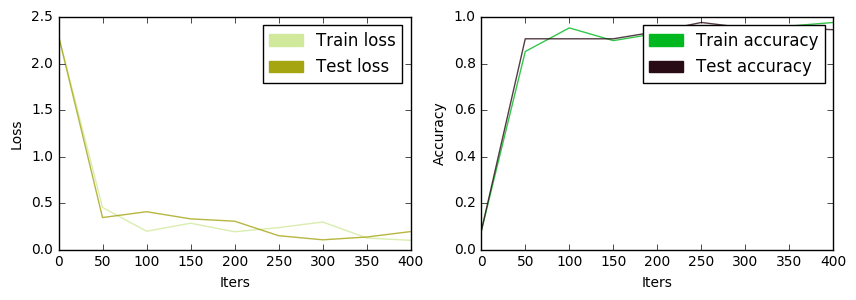

In [112]:
plot_losses_acc(losses, acc, interval)

In [113]:
# SGD
model = myConvNet(np_images_train.shape[2])
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
interval = 50
losses, acc = learn(model, optimizer, 1, np_images_train, np_labels_train,
                    np_images_test, np_labels_test, interval)

100%|██████████| 411/411 [00:47<00:00,  8.72it/s]


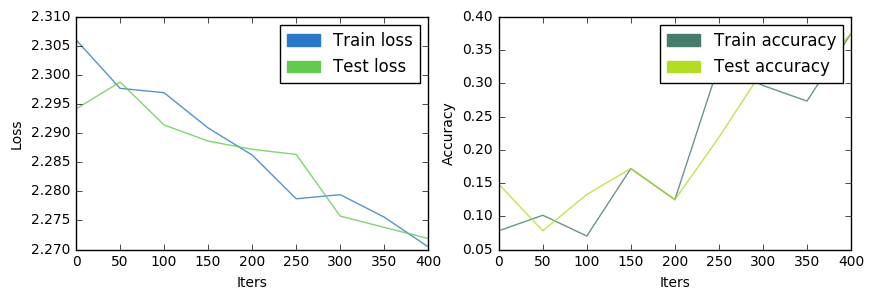

In [114]:
plot_losses_acc(losses, acc, interval)

In [122]:
# NAG
model = myConvNet(np_images_train.shape[2])
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9, nesterov = True)
interval = 50
losses, acc = learn(model, optimizer, 1, np_images_train, np_labels_train,
                    np_images_test, np_labels_test, interval)

100%|██████████| 411/411 [00:45<00:00,  9.04it/s]


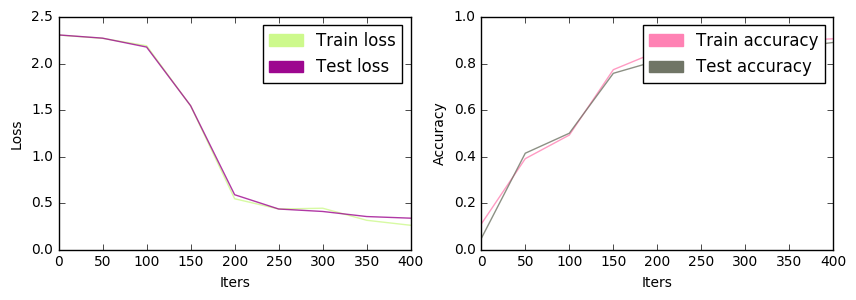

In [123]:
plot_losses_acc(losses, acc, interval)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: